# Photometric Inference

This notebook outlines the basics of how to conduct basic redshift inference using **photometry** (i.e. a set of observed **features**) rather than directly over (noisy) redshifts (i.e. **labels**).

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated.

In [3]:
survey = pickle.load(open('../data/mock_sdss_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types']  # type flag
templates = survey.data['templates']  # template ID
redshifts = survey.data['redshifts']  # redshift
mags = survey.data['refmags']  # magnitude (reference)
phot_obs = survey.data['phot_obs']  # observed photometry
phot_err = survey.data['phot_err']  # photometry error
phot_true = survey.data['phot_true']  # true photometry
Nobs = len(types)

# Overview

In the original redshift case used in Part 2, for every observed galaxy $g \in \mathbf{g}$ out of $N_\mathbf{g}$ galaxies, we assumed we had an associated redshift estimate $z_g$ with PDF $P(z_g | z)$. We were interested in constructing an estimate for the population redshift distribution $N(z|\mathbf{g})$ by projecting our results onto a relevant **redshift basis** $\lbrace \dots, P(z_h|z) = K(z_h|z), \dots \rbrace$ indexed by $h \in \mathbf{h}$ via

$$
P(g|h) \rightarrow P(z_g|z_h) = \frac{P(z_g, z_h)}{P(z_h)} = \frac{\int P(z_g | z) P(z_h | z) P(z) dz}{\sum_{g \in \mathbf{g}} \int P(z_g | z) P(z_h | z) P(z) dz}
$$

Here, we want to do this same exercise over our set of observed $p$-dimensional **features** to construct an associated estimate $N(\mathbf{F}|\mathbf{g})$

$$
P(g|h) \rightarrow P(\mathbf{F}_g|\mathbf{F}_h) = \frac{P(\mathbf{F}_g, \mathbf{F}_h)}{P(\mathbf{F}_h)} = \frac{\int P(\mathbf{F}_g | \mathbf{F}) P(\mathbf{F}_h | \mathbf{F}) P(\mathbf{F}) d\mathbf{F}}{\sum_{g \in \mathbf{g}} \int P(\mathbf{F}_g | \mathbf{F}) P(\mathbf{F}_h | \mathbf{F}) P(\mathbf{F}) d\mathbf{F}}
$$

where $\mathbf{F}_i$ is now a $p$-dimensional vector. In our case, we will assume these set of features correspond to a set of observed **flux densities** $F_{i,b}$ in a set of **photometric bands** $b \in \mathbf{b}$.

In the case where our basis is noiseless such that $P(\mathbf{F}_h|\mathbf{F}) = \delta(\mathbf{F}_h - \mathbf{F})$ (where $\delta(\cdot)$ is the multivariate Dirac delta function) and our prior $P(\mathbf{F}) = 1$ is uniform, this just reduces to

$$ P(g|h) = \frac{P(\mathbf{F}_g|\mathbf{F}_h)}{\sum_{g \in \mathbf{g}} K(\mathbf{F}_g|\mathbf{F}_h)} $$

which is just the value of the observed PDF $P(\mathbf{F}_g|\mathbf{F})$ evaluated at $\mathbf{F}_h$.

## Photometric Redshifts

We can define our projection over this basis using **Bayes Theorem** as

$$
P(h|\mathbf{g}) \equiv \sum_{g \in \mathbf{g}} P(h|g) = \sum_{g \in \mathbf{g}} \frac{P(g|h)P(h)}{P(g)}
$$

where $P(h|g)$ is the **posterior**, $P(g|h)$ is the **likelihood**, $P(h)$ is the **prior**, and

$$
P(g)=\sum_{h \in \mathbf{h}} P(g|h)P(h)
$$

is the **evidence** (also known as the marginal likelihood).

In practice, $\mathbf{g}$ constitutes a set of **target objects** with **unknown** properties while $\mathbf{h}$ is a set of **training objects** with **known** properties. We are interested in inferring the redshift PDF $P(z|g)$ for our observed object $g$. Given $\mathbf{h}$, this is just

$$ 
P(z|g) = \frac{\sum_{h \in \mathbf{h}} K(z|g,h)P(g|h)P(h)}{\sum_{h \in \mathbf{h}} P(g|h)P(h) \int K(z|g,h) dz} 
$$

where $K(\cdot)$ is just a change in notation meant to suggest a redshift **kernel**.

**Ignoring any possible covariant structure in $K(z|g,h)$** and assuming $\int K(z|g,h)dz = \int K(z|h)dz = 1$, this reduces to

$$ 
P(z|g) = \frac{\sum_{h \in \mathbf{h}} K(z|h)P(g|h)P(h)}{\sum_{h \in \mathbf{h}} P(g|h)P(h)} = \sum_{h \in \mathbf{h}} K(z|h) \frac{P(g|h)P(h)}{P(g)} = \sum_{h \in \mathbf{h}} K(z|h) P(h|g)
$$

which is a posterior-weighted mixture of the $K(z|h)$ redshift kernels.

# The "Big Data" Approximation

It is important to note that we've made a pretty big assumption here: **that we can reduce a continuous process over $\mathbf{F}$ to a discrete set of comparisons over our training data $\mathbf{h}$**. This choice constitutes a **"Big Data" approximation** that necessarily introduces some (Poisson) noise into our estimates, and is designed to take advantage of datasets where many ($\gtrsim 10^4$ or so) training objects are available such that our parameter space is (relatively) densely sampled. We will investigate this more explicitly later.

# Our Prior

In this particular case, our prior $P(h)=P(z_h,t_h,m_h)$ is defined over a series of models parameterized by magnitude, type, and redshift as described in Part 1. These are saved within our original survey object and briefly shown below.

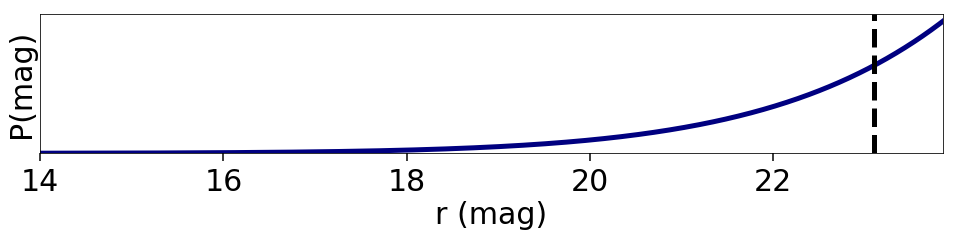

In [4]:
# plotting magnitude prior
plt.figure(figsize=(14, 4))
depths = np.array([f['depth_mag5sig'] for f in survey.filters])
mdepth = depths[survey.ref_filter]
mhigh = mdepth + 2.5 * np.log10(2)
mgrid = np.arange(14., mhigh + 0.01, 0.01)
plt.plot(mgrid, survey.pm(mgrid, mdepth), lw=5, color='navy')
plt.axvline(mdepth, ls='--', lw=5, color='black')
plt.xlabel(survey.filters[survey.ref_filter]['name'] + ' (mag)')
plt.xlim([14., mhigh])
plt.ylabel('P(mag)')
plt.ylim([0., None])
plt.yticks([])
plt.tight_layout()

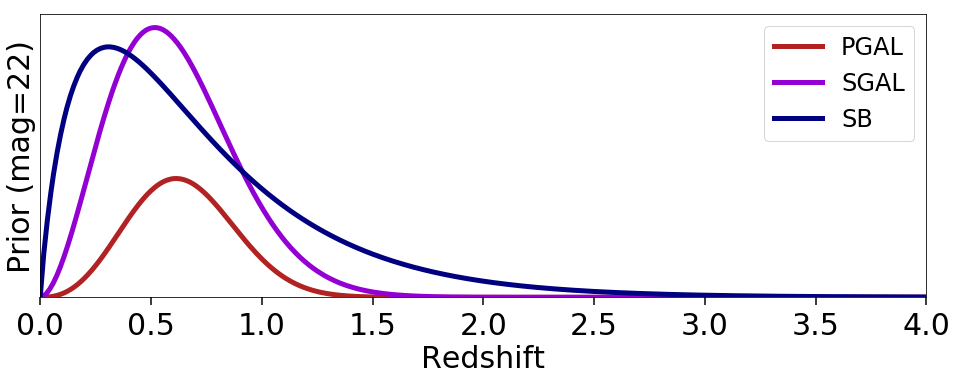

In [5]:
# plotting prior
mag = 22
zgrid = np.linspace(0., 4., 1000)
pcolors = ['firebrick', 'darkviolet', 'navy']  # prior colors

plt.figure(figsize=(14, 6))
for i in range(survey.NTYPE):
    pztm = [survey.pztm(z, i, mag) for z in zgrid]
    plt.plot(zgrid, pztm, lw=5, color=pcolors[i],
             label=survey.TYPES[i])
plt.xlabel('Redshift')
plt.xlim([0, 4])
plt.ylabel('Prior (mag={0})'.format(mag))
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=24)
plt.tight_layout()

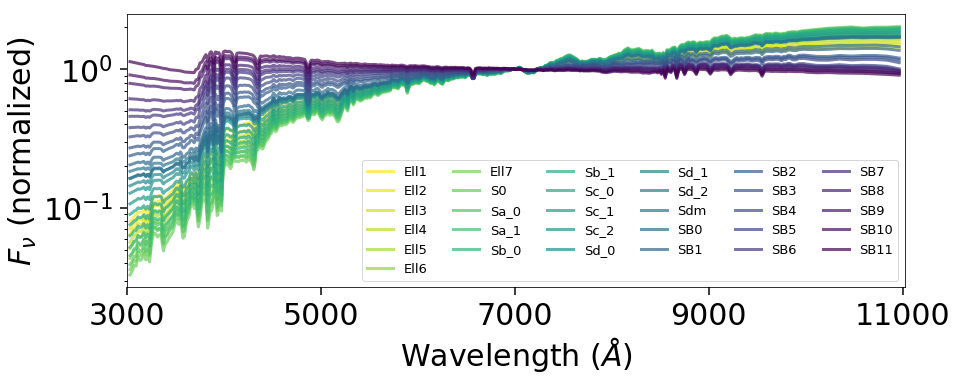

In [6]:
# plotting templates
tcolors = plt.get_cmap('viridis_r')(np.linspace(0., 1., survey.NTEMPLATE)) # template colors
xlow = min([min(f['wavelength']) for f in survey.filters])  # lower bound
xhigh = max([max(f['wavelength']) for f in survey.filters])  # upper bound
plt.figure(figsize=(14, 6))
for t, c in zip(survey.templates, tcolors):
    wave, fnu, name = t['wavelength'], t['fnu'], t['name']
    sel = (wave > xlow) & (wave < xhigh)
    plt.semilogy(wave[sel], fnu[sel], lw=3, color=c,
                 label=name, alpha=0.7)
plt.xlim([xlow, xhigh])
plt.xticks(np.arange(3000., 11000.+1., 2000.))
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'$F_{\nu}$ (normalized)')
plt.legend(ncol=int(survey.NTEMPLATE/6 + 1), fontsize=13, loc=4)
plt.tight_layout()

# Photometric Likelihoods

For most galaxies, we can approximate $K_g(\mathbf{F}|\mathbf{\hat{F}}_h)$ as a **multivariate Normal** (i.e. Gaussian) distribution such that

$$ 
P(\mathbf{F}_g|\mathbf{F}) = \mathcal{N}(\mathbf{F}_g|\boldsymbol{\mu}=\mathbf{\hat{F}},\mathbf{C}=\mathbf{C}_g) 
\equiv \frac{\exp\left[-\frac{1}{2}||\mathbf{F}_g-\mathbf{F}||_{\mathbf{C}_g^{-1}}^2\right]}{(2\pi)^{N_\mathbf{b}/2}|\mathbf{C}_g|^{1/2}} 
$$

where

$$ 
||\mathbf{F}-\mathbf{F}||_{\mathbf{C}^{-1}}^2 \equiv (\mathbf{F}_g-\mathbf{F})^T\mathbf{C}_g^{-1}(\mathbf{F}_g-\mathbf{F}) 
$$

is the **squared Mahalanobis distance** for vector $\mathbf{F}_g-\mathbf{F}$, $\mathbf{C}_g$ is the **covariance matrix** (i.e. the observed errors), $\mathbf{C}_g^{-1}$ is the corresponding **precision matrix**, $T$ is the transpose operator, $N_{\mathbf{b}}$ is the total number of bands, and $|\mathbf{C}_g|$ is the **determinant** of $\mathbf{C}_g$.

**While we will use matrix notation for compactness, in practice we will assume all our covariances are diagonal (i.e. the errors are independent)** such that

$$
||\mathbf{F}_g-\mathbf{F}||_{\mathbf{C}_g^{-1}} = \sum_{b \in \mathbf{b}} \frac{(F_{g,b}-F_b)^2}{\hat{\sigma}^2_{g,b}} \equiv \chi^2
$$

which is the typical **chi-square statistic**.

## Likelihood: Magnitudes

We first look at the simplest case: a direct observational comparison over $\mathbf{F}$ (i.e. galaxy **magnitudes**).

The product of two multivariate Normal distributions $\mathcal{N}(\mathbf{F}_g|\mathbf{F},\mathbf{C}_g)$ and $\mathcal{N}(\mathbf{F}_h|\mathbf{F},\mathbf{C}_h)$ is a scaled multivariate Normal of the form $S_{gh}\,\mathcal{N}(\mathbf{F}_{gh}|\mathbf{F},\mathbf{C}_{gh})$ where

$$
S_{gh} \equiv \mathcal{N}(\mathbf{F}_g|\mathbf{F}_h,\mathbf{C}_{g+h}), \quad 
\mathbf{C}_{g+h} \equiv \mathbf{C}_g+\mathbf{C}_h, \quad
\mathbf{F}_{gh} \equiv \mathbf{C}_{gh} \left( \mathbf{C}_g^{-1}\mathbf{F}_g + \mathbf{C}_h^{-1}\mathbf{F}_h \right), \quad
\mathbf{C}_{gh} \equiv \left(\mathbf{C}_g^{-1}+\mathbf{C}_h^{-1}\right)^{-1} \quad .
$$

If we assume a uniform prior on our flux densities $P(\mathbf{F})=1$, our log-likelihood can then be written as

\begin{equation}
\boxed{
-2\ln P(g|h) = ||\mathbf{F}_g - \mathbf{F}_h||_{\mathbf{C}_{g+h}^{-1}}^2 + N_\mathbf{b}\ln(2\pi) + \ln|\mathbf{C}_{g+h}|
}
\end{equation}

Let's compute an example PDF using `frankenz` for objects in our mock catalog. Since these are sampled from the prior, we've actually introduced our prior *implicitly* via the *distribution of objects* in our training sample, the same way as Part 2.4. As a result, computing likelihoods directly in magnitudes actually probes (with some noise) the full *posterior* (as defined by BPZ).

We compare two versions of our results: 
- **Noiseless case**: computed using the "true" underlying photometry underlying each training object.
- **Noisy case**: computed using our "observed" mock photometry.

In [7]:
# sample good example object
idx = np.random.choice(np.arange(Nobs)[(mags < 22.5) & (mags > 22)])

In [8]:
# compute loglikelihoods (noiseless)
ll, nb = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                              np.ones(survey.NFILTER),
                              phot_true, np.zeros_like(phot_true), 
                              np.ones_like(phot_true), 
                              dim_prior=False)

# compute loglikelihoods (noisy)
ptemp = np.random.normal(phot_true, phot_err)  # avoid exact duplicates
ll2, nb2 = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                np.ones(survey.NFILTER),
                                ptemp, phot_err, 
                                np.ones_like(phot_true),
                                dim_prior=False)

In [9]:
# define plotting functions

def plot_flux(phot_obs, phot_err, phot, logl, 
              ocolor='black', mcolor='blue', thresh=1e-1):
    """Plot SEDs."""

    wave = np.array([f['lambda_eff'] for f in survey.filters])
    wt = np.exp(logl)
    wtmax = wt.max()
    sel = np.arange(len(phot))[wt > thresh * wtmax]
    [plt.plot(wave, phot[i], alpha=wt[i]/wtmax*0.4, lw=3, 
              zorder=1, color=mcolor) for i in sel]
    plt.errorbar(wave, phot_obs, yerr=phot_err, lw=3, color=ocolor, zorder=2)
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.xlim([wave.min() - 100, wave.max() + 100])
    plt.ylim([(phot_obs - phot_err).min() * 0.9, (phot_obs + phot_err).max() * 1.1])
    plt.ylabel(r'$F_\nu$')
    plt.yticks(fontsize=24)
    plt.tight_layout()
    
def plot_redshift(redshifts, logl, ztrue=None, color='yellow', 
                  tcolor='red'):
    """Plot redshift PDF."""
    
    n, _, _ = plt.hist(redshifts, bins=zgrid, weights=np.exp(logl), 
                       histtype='stepfilled', edgecolor='black',
                       lw=3, color=color, alpha=0.8)
    if ztrue is not None:
        plt.vlines(ztrue, 0., n.max() * 1.1, color=tcolor, linestyles='--', lw=2)
    plt.xlabel('Redshift')
    plt.ylabel('PDF')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.ylim([0., n.max() * 1.1])
    plt.yticks([])
    plt.tight_layout()

def plot_zt(redshifts, templates, logl, ztrue=None, ttrue=None,
            cmap='viridis', tcolor='red', thresh=1e-2):
    """Plot joint template-redshift PDF."""
    from scipy.misc import logsumexp
    lsum = logsumexp(logl)
    wt = np.exp(logl - lsum)
    plt.hist2d(redshifts, templates, bins=[zgrid, tgrid],
               weights=wt, 
               cmin=thresh*max(wt),
               cmap=cmap)
    if ttrue is not None:
        plt.hlines(ttrue, zgrid.min(), zgrid.max(), 
                   color=tcolor, lw=2, linestyles='--')
    if ztrue is not None:
        plt.vlines(ztrue, tgrid.min(), tgrid.max(), 
                   color=tcolor, lw=2, linestyles='--')
    plt.xlabel('Redshift')
    plt.ylabel('Template')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.ylim([tgrid[0], tgrid[-1]])
    plt.tight_layout()

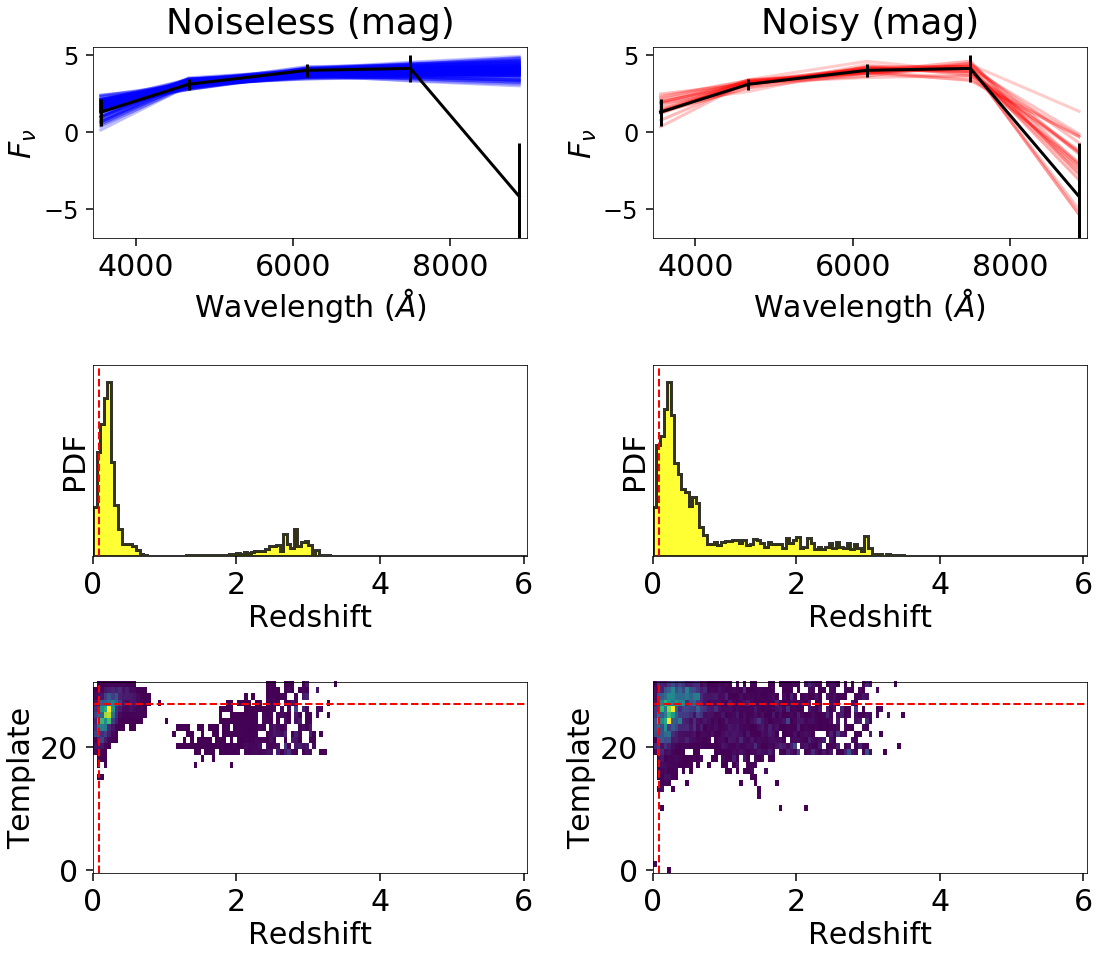

In [10]:
# plot flux distribution
plt.figure(figsize=(16, 14))
plt.subplot(3,2,1)
plot_flux(phot_obs[idx], phot_err[idx], phot_true, ll, 
          ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Noiseless (mag)', y=1.04)
plt.subplot(3,2,2)
plot_flux(phot_obs[idx], phot_err[idx], ptemp, ll2, 
          ocolor='black', mcolor='red', thresh=0.5)
plt.title('Noisy (mag)', y=1.04);

# plot redshift distribution
zgrid = np.arange(0., 6. + 0.1, 0.05)
plt.subplot(3,2,3)
plot_redshift(redshifts, ll, ztrue=redshifts[idx])
plt.subplot(3,2,4)
plot_redshift(redshifts, ll2, ztrue=redshifts[idx])

# plot redshift-type joint distribution
tgrid = np.arange(survey.NTEMPLATE + 1) - 0.5
plt.subplot(3,2,5)
plot_zt(redshifts, templates, ll,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.subplot(3,2,6)
plot_zt(redshifts, templates, ll2,
        ztrue=redshifts[idx], ttrue=templates[idx])

As expected, the PDF computed from our noisy photometry is broader than than the noiseless case. This is exactly analagous to our redshift example in Part 2.

## Likelihood: Colors

We can also defined our likelihoods in terms of **flux ratios** (i.e. galaxy **"colors"**) by introducing a scaling parameter $\alpha$. Assuming $P(\mathbf{F},\alpha) = P(\mathbf{F})P(\alpha)$ and $P(\mathbf{F}=1$ is uniform this takes the form

$$
P_C(g|h) = \int P(\alpha) \mathcal{N}\left(\mathbf{F}_g | \alpha\mathbf{F}_h,\mathbf{C}_{g+h}(\alpha)\right)\,d\alpha
$$

where 

$$
\mathbf{C}_{g+h}(\alpha) \equiv \mathbf{C}_{g}+\alpha^2\mathbf{C}_{h}
$$

This integral does not have an analytic solution although we can numerically solve for the maximum-likelihood result. However, **if we assume that $\mathbf{\hat{C}}_h = \mathbf{0}$** (i.e. no model errors), then there is an analytic solution with log-likelihood

\begin{equation}
\boxed{
-2\ln P_C(g|h) = ||\mathbf{F}_g - \alpha_{\textrm{ML}}\mathbf{F}_h||_{\mathbf{C}_{g+h}^{-1}(\alpha_{\textrm{ML}})}^2 + N_\mathbf{b}\ln(2\pi) + \ln|\mathbf{C}_{g+h}(\alpha_{\textrm{ML}})|
}
\end{equation}

where

$$
\alpha_{\mathrm{ML}} = \frac{\gamma^2}{2}\left(\mathbf{F}_g^T\mathbf{C}_g^{-1}\mathbf{F}_h 
+ \mathbf{F}_h^T \mathbf{C}_g^{-1} \mathbf{F}_g\right), \quad
\gamma = \left(\mathbf{F}_h^T\mathbf{C}_g^{-1}\mathbf{F}_h^T\right)^{-1/2}
$$

We can now repeat the above exercise using our color-based likelihoods. As above, we compare two versions:
- **Noiseless case**: computed using the "true" underlying photometry underlying each training object.
- **Noisy case**: computed using our "observed" mock photometry.

In [11]:
# compute color loglikelihoods (noiseless)
llc, nbc, s = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                   np.ones(survey.NFILTER),
                                   phot_true, phot_err, 
                                   np.ones_like(phot_true), 
                                   dim_prior=False, free_scale=True, 
                                   ignore_model_err=True, return_scale=True)

# compute color loglikelihoods (noisy)
llc2, nbc2, s2 = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                      np.ones(survey.NFILTER),
                                      ptemp, phot_err, 
                                      np.ones_like(phot_true), 
                                      dim_prior=False, free_scale=True, 
                                      ignore_model_err=False, return_scale=True)

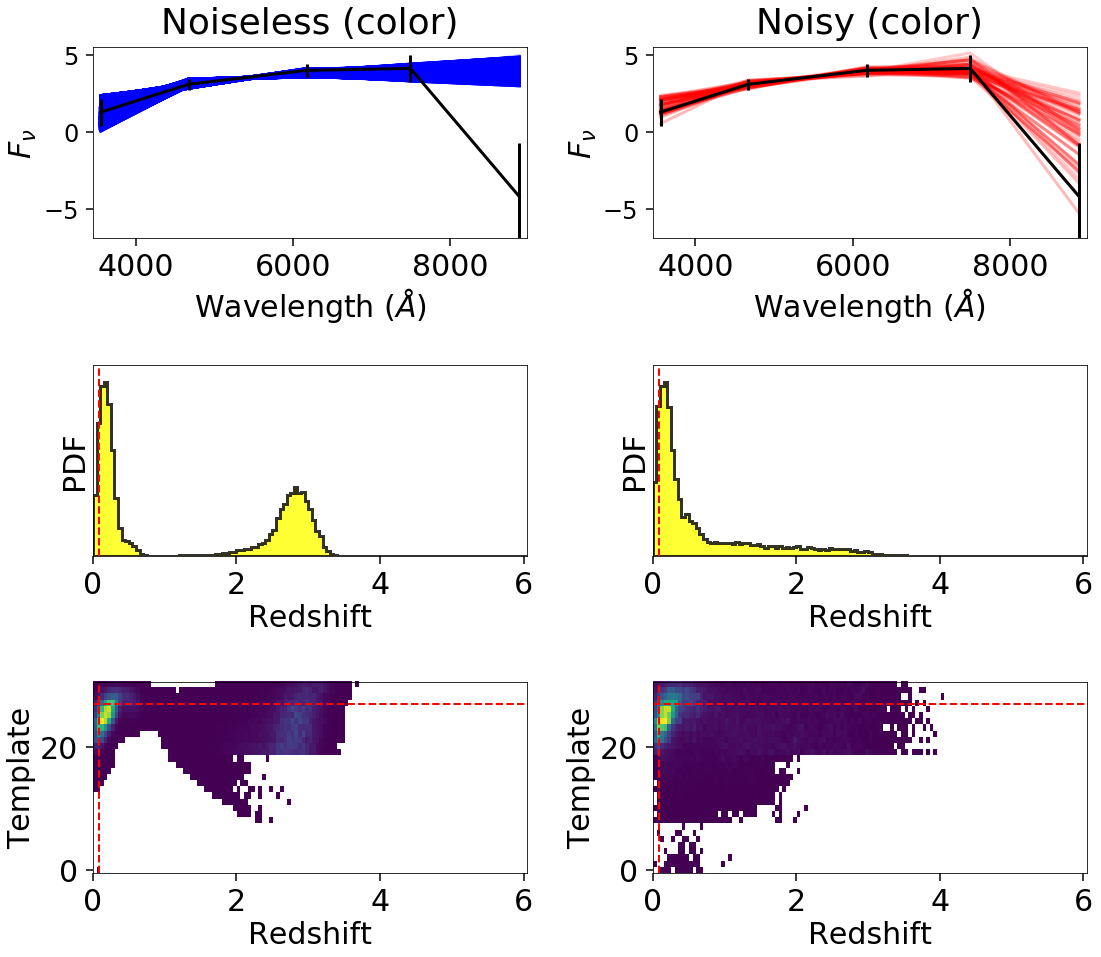

In [12]:
# plot flux distribution
plt.figure(figsize=(16, 14))
plt.subplot(3,2,1)
plot_flux(phot_obs[idx], phot_err[idx], s[:, None] * phot_true,
          llc, ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Noiseless (color)', y=1.04)
plt.subplot(3,2,2)
plot_flux(phot_obs[idx], phot_err[idx], s2[:, None] * ptemp,
          llc2, ocolor='black', mcolor='red', thresh=0.5)
plt.title('Noisy (color)', y=1.04);

# plot redshift distribution
plt.subplot(3,2,3)
plot_redshift(redshifts, llc, ztrue=redshifts[idx])
plt.subplot(3,2,4)
plot_redshift(redshifts, llc2, ztrue=redshifts[idx])

# plot redshift-type joint distribution
plt.subplot(3,2,5)
plot_zt(redshifts, templates, llc, thresh=1e-2,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.subplot(3,2,6)
plot_zt(redshifts, templates, llc2, thresh=1e-2,
        ztrue=redshifts[idx], ttrue=templates[idx])

Finally, it's useful to compare the case where we compute our posteriors directly from our underlying model grid and apply our priors directly. By construction, this should agree with the "true" posterior distribution.

In [13]:
# compute color loglikelihoods over grid
mphot = survey.models['data'].reshape(-1, survey.NFILTER)
merr = np.zeros_like(mphot)
mmask = np.ones_like(mphot)
llm, nbm, sm = frankenz.pdf.loglike(phot_obs[idx], phot_err[idx], 
                                    np.ones(survey.NFILTER),
                                    mphot, merr, mmask,
                                    dim_prior=False, free_scale=True, 
                                    ignore_model_err=True, return_scale=True)

In [14]:
# compute prior
mzgrid = survey.models['zgrid']
ttypes = np.array([np.arange(survey.NTYPE)[t['type'] == survey.TYPES] 
                   for t in survey.templates], dtype='int').flatten()
prior = np.array([frankenz.priors.bpz_pz_tm(mzgrid, t, mags[idx]) 
                  for t in ttypes]).T.flatten()

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


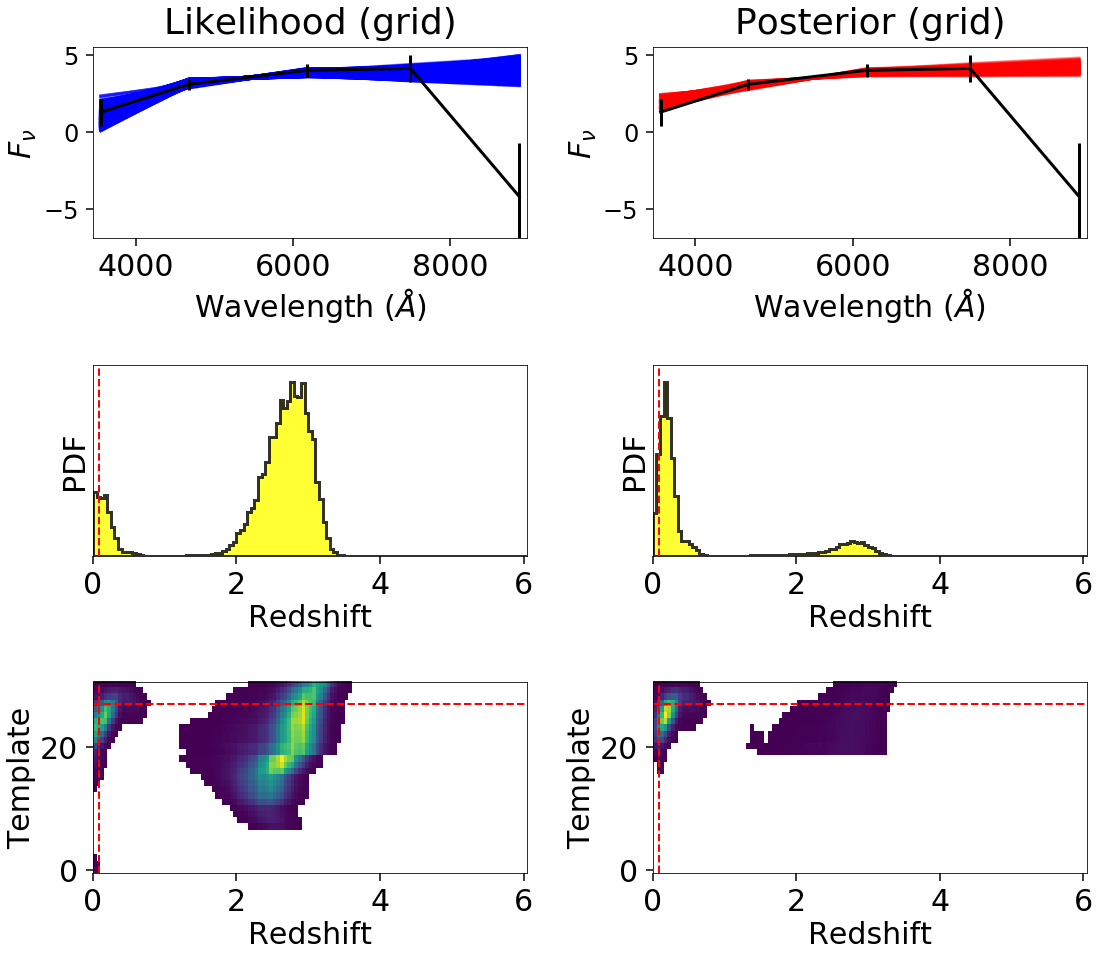

In [15]:
# plot flux distribution
plt.figure(figsize=(16, 14))
plt.subplot(3,2,1)
plot_flux(phot_obs[idx], phot_err[idx], sm[:, None] * mphot,
          llm, ocolor='black', mcolor='blue', thresh=0.5)
plt.title('Likelihood (grid)', y=1.04)
plt.subplot(3,2,2)
plot_flux(phot_obs[idx], phot_err[idx], sm[:, None] * mphot,
          llm + np.log(prior).flatten(), 
          ocolor='black', mcolor='red', thresh=0.5)
plt.title('Posterior (grid)', y=1.04);

# plot redshift distribution
mredshifts = np.array([mzgrid for i in range(survey.NTEMPLATE)]).T.flatten()
plt.subplot(3,2,3)
plot_redshift(mredshifts, llm, ztrue=redshifts[idx])
plt.subplot(3,2,4)
plot_redshift(mredshifts, llm + np.log(prior).flatten(),
              ztrue=redshifts[idx])

# plot redshift-type joint distribution
mtemplates = np.array([np.arange(survey.NTEMPLATE) 
                       for i in range(len(mzgrid))]).flatten()
plt.subplot(3,2,5)
plot_zt(mredshifts, mtemplates, llm, thresh=1e-2,
        ztrue=redshifts[idx], ttrue=templates[idx])
plt.subplot(3,2,6)
plot_zt(mredshifts, mtemplates, llm + np.log(prior).flatten(),
        thresh=1e-2, ztrue=redshifts[idx], ttrue=templates[idx])

As expected, the secondary solutions seen in our grid-based likelihoods are suppressed by our prior, which indicates many of these solutions are distinctly unphysical (at least given the original assumptions used when constructing our mock).

In addition, the BPZ posterior computed over our grid of models agrees quite well with the noiseless flux-based likelihoods computed over our samples (i.e. "training data"). This demonstrates that an utilizing an unbiased, representative training set instead of a grid of models inherently gives access to complex priors that otherwise have to be modeled analytically. However, such a representation is often not true in practice. We hope to account for this behavior using the hierarchical models demonstrated in Part 2.

# Population Tests

We now want to see how things look on a larger sample of objects.

In [16]:
sel = (phot_obs / phot_err)[:, survey.ref_filter] > 5.  # S/N > 5 cut
Nsel = sel.sum()

Ntrain, Ntest = 60000, 5000
train_sel = np.arange(Nobs)[sel][:Ntrain]  # training set
test_sel = np.arange(Nobs)[sel][Ntrain:Ntrain+Ntest]  # testing set
Nmodel = len(mphot)

print('Number of observed galaxies (all):', Nobs)
print('Number of observed galaxies (selected):', Nsel)
print('Number of models:', Nmodel)
print('Number of training galaxies:', Ntrain)
print('Number of testing galaxies:', Ntest)

Number of observed galaxies (all): 200000
Number of observed galaxies (selected): 67951
Number of models: 31000
Number of training galaxies: 60000
Number of testing galaxies: 5000


## Sidenote: KDE in `frankenz`

One of the ways `frankenz` differs from other photometric redshift (photo-z) codes is that it tries to avoid discretizing quantities whenever and wherever possible. Since redshifts, flux densities, and many other photometric quantities are **continuous with smooth PDFs**, we attempt to work directly in this continuous space whenever possible instead of resorting to binning.

As in the last set of notebooks, we accomplish this through **kernel density estimation (KDE)**. Since almost all photometric observable PDFs are Gaussian, by connecting each observable with an associated Gaussian kernel density we can *in theory* construct a density estimate at any location in parameter space by evaluating the probability density of all kernels at that location.

In practice, such a brute-force approach is prohibitively computationally expensive. Instead, we approximate the contribution from any particular object by (1) evaluating only a small subset of "nearby" kernels, (2) evaluating the overall kernel density estimates over a discrete basis, and (3) evaluating only the "central regions" of our kernels. This is implemented within the `gauss_kde` function in the `frankenz.pdf` module, which we've already been using.

In addition, we can also use a stationary **pre-computed dictionary** of Gaussian kernels to discretize our operations. This avoids repetitive, expensive computations at the (very small) cost of increased memory overhead and errors from imposing a minimum resolution. This is implemented via the `PDFDict` class and the `gauss_kde_dict` function. We will use the option whenever possible going forward.

## Magnitude Distribution

Let's use this functionality to visualize the stacked magnitude distribution of our population.

In [17]:
# initialize asinh magnitudes ("Luptitudes")
flux_zeropoint = 10**(-0.4 * -23.9) # AB magnitude zeropoint
fdepths = np.array([f['depth_flux1sig'] for f in survey.filters])
mag, magerr = frankenz.pdf.asinh_mag(phot_obs, phot_err, skynoise=fdepths,
                                     zeropoints=flux_zeropoint)

# initialize magnitude dictionary 
mdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(-20., 60., 5e-3), 
                             sigma_grid=np.linspace(0.01, 5., 500))

Note that we've used asinh magnitudes (i.e. "Luptitudes"; [Lupton et al. 1999](http://adsabs.harvard.edu/abs/1999AJ....118.1406L)) rather than log10 magnitudes in order to incorporate data with negative measured fluxes.

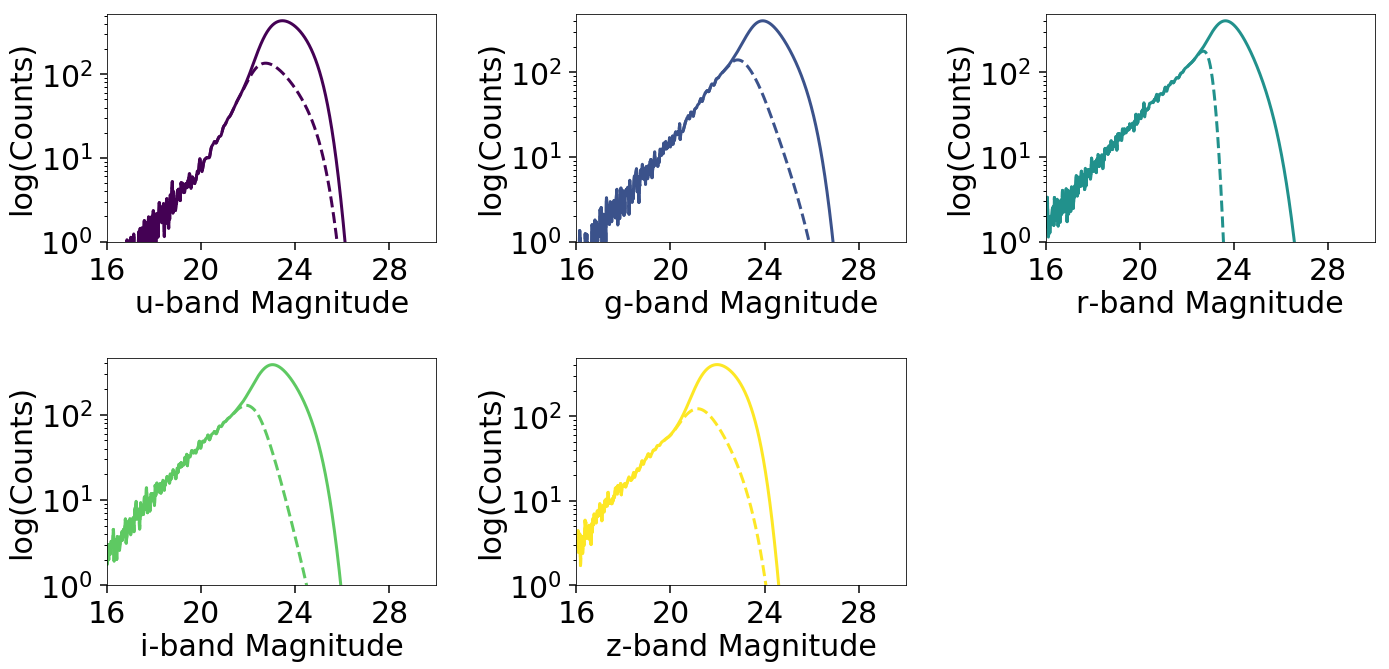

In [18]:
# plotting magnitude distribution
fcolors = plt.get_cmap('viridis')(np.linspace(0,1, survey.NFILTER))
plt.figure(figsize=(20, 10))
for i in range(survey.NFILTER):
    plt.subplot(2, int(survey.NFILTER/2)+1, i+1)
    # compute pdf
    mag_pdf = frankenz.pdf.gauss_kde_dict(mdict, y=mag[:, i],
                                          y_std=magerr[:, i])  # all
    plt.semilogy(mdict.grid, mag_pdf, lw=3, color=fcolors[i])
    magsel_pdf = frankenz.pdf.gauss_kde_dict(mdict, y=mag[sel, i],
                                             y_std=magerr[sel, i])  # selected
    plt.semilogy(mdict.grid, magsel_pdf, lw=3, color=fcolors[i], ls='--')
    plt.xlim([16, 30])
    plt.ylim([1., mag_pdf.max() * 1.2])
    plt.xticks(np.arange(16, 30, 4))
    plt.xlabel(survey.filters[i]['name'] + '-band Magnitude')
    plt.ylabel('log(Counts)')
    plt.tight_layout()

## Redshift Distribution

In [19]:
# initialize redshift dictionary
rdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(0., 7.+1e-5, 0.01), 
                             sigma_grid=np.linspace(0.005, 2., 500))

Let's now compute our effective redshift PDF.

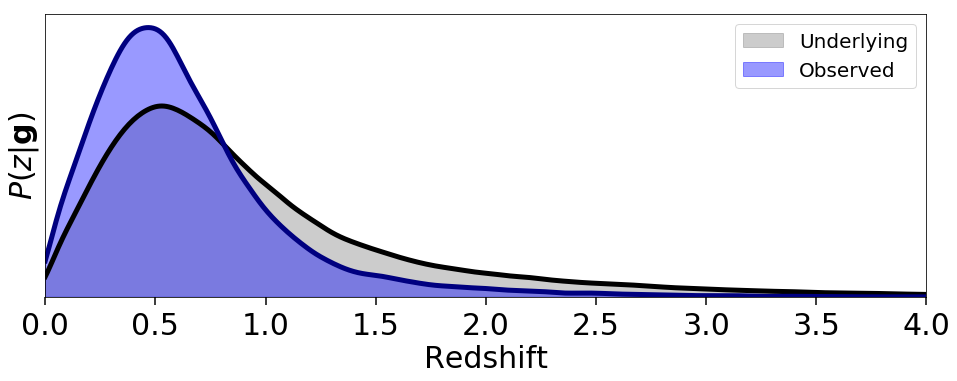

In [20]:
# plotting redshift distribution
plt.figure(figsize=(14, 6))
rsmooth = 0.05

# all
z_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts,
                                    y_std=np.ones_like(redshifts) * rsmooth)
plt.plot(rdict.grid, z_pdf / z_pdf.sum(), lw=5, color='black')
plt.fill_between(rdict.grid, z_pdf / z_pdf.sum(), color='gray',
                 alpha=0.4, label='Underlying')

# selected
zsel_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[sel],
                                       y_std=np.ones_like(redshifts[sel]) * rsmooth)
plt.plot(rdict.grid, zsel_pdf / zsel_pdf.sum(), lw=5, color='navy')
plt.fill_between(rdict.grid, zsel_pdf / zsel_pdf.sum(), 
                 color='blue', alpha=0.4, label='Observed')

# prettify
plt.xlim([0, 4])
plt.ylim([0, None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

# Comparison 1: Mag (samples) vs Color (grid)

As a first proof of concept, we want to just check whether the population distribution inferred from our samples (using magnitudes) agree with those inferred from our underlying model grid (using colors).

In [21]:
# initialize datasets
phot_train, phot_test = phot_obs[train_sel], phot_obs[test_sel]
err_train, err_test = phot_err[train_sel], phot_err[test_sel]
mask_train, mask_test = np.ones_like(phot_train), np.ones_like(phot_test)

In [22]:
from scipy.misc import logsumexp

pstack1, pstack2, pstack3 = np.zeros(Ntrain), np.zeros(Nmodel), np.zeros(Nmodel)

for i in range(Ntest):
    if i%500 == 0: 
        sys.stderr.write(str(i)+' ')
    mag = mags[test_sel[i]]
    ll, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                      phot_train, err_train, mask_train)
    ll2, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                       mphot, merr, mmask,
                                       ignore_model_err=True, free_scale=True)
    
    prior = np.array([frankenz.priors.bpz_pz_tm(mzgrid, t, mag) for t in ttypes]).T.flatten()
    lpost = np.log(prior) + ll2
    
    pstack1 += np.exp(ll - logsumexp(ll))
    pstack2 += np.exp(ll2 - logsumexp(ll2))
    pstack3 += np.exp(lpost - logsumexp(lpost))

0 /home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
500 1000 1500 2000 2500 3000 3500 4000 4500 

In [23]:
# true distribution
zpdf0 = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[test_sel],
                                    y_std=np.ones_like(test_sel) * rsmooth)

# mag samples likelihood
zpdf1 = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[train_sel],
                                    y_std=np.ones_like(train_sel) * rsmooth, 
                                    y_wt=pstack1)

# color grid likelihood
zpdf2 = frankenz.pdf.gauss_kde_dict(rdict, y=mredshifts,
                                    y_std=np.ones_like(mredshifts) * rsmooth, 
                                    y_wt=pstack2)

# color grid posterior
zpdf3 = frankenz.pdf.gauss_kde_dict(rdict, y=mredshifts,
                                    y_std=np.ones_like(mredshifts) * rsmooth, 
                                    y_wt=pstack3)

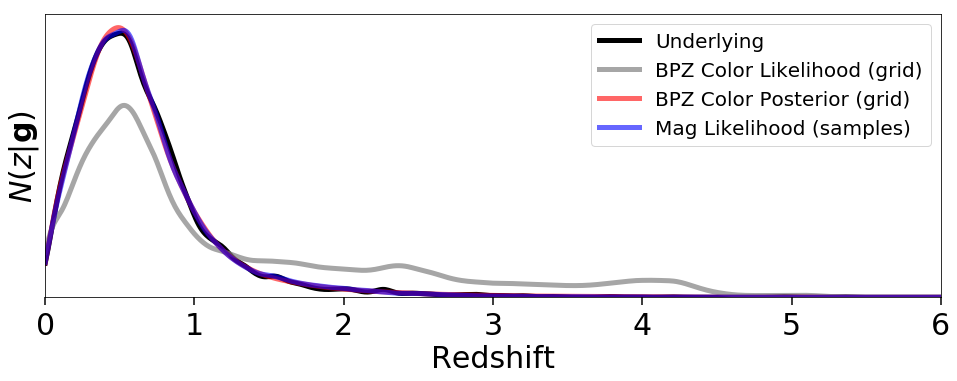

In [24]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, zpdf2, lw=5, color='gray', alpha=0.7,
         label='BPZ Color Likelihood (grid)')
plt.plot(rdict.grid, zpdf3, lw=5, color='red', alpha=0.6, 
         label='BPZ Color Posterior (grid)')
plt.plot(rdict.grid, zpdf1, lw=5, color='blue', alpha=0.6,
         label='Mag Likelihood (samples)')
plt.xlim([0., 6.])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

We see that the population redshift distribution $N(z|\mathbf{g})$ computed from our noisy fluxes is very close to that computed by the intrinsic BPZ posterior (which is exactly correct *by design*). These both differ markedly from the color-based likelihoods computed over our noiseless grid, demonstrating the impact of the prior for data observed at moderate/low signal-to-noise (S/N). We can see this in more detail by looking at the joint distributions between template and redshift.

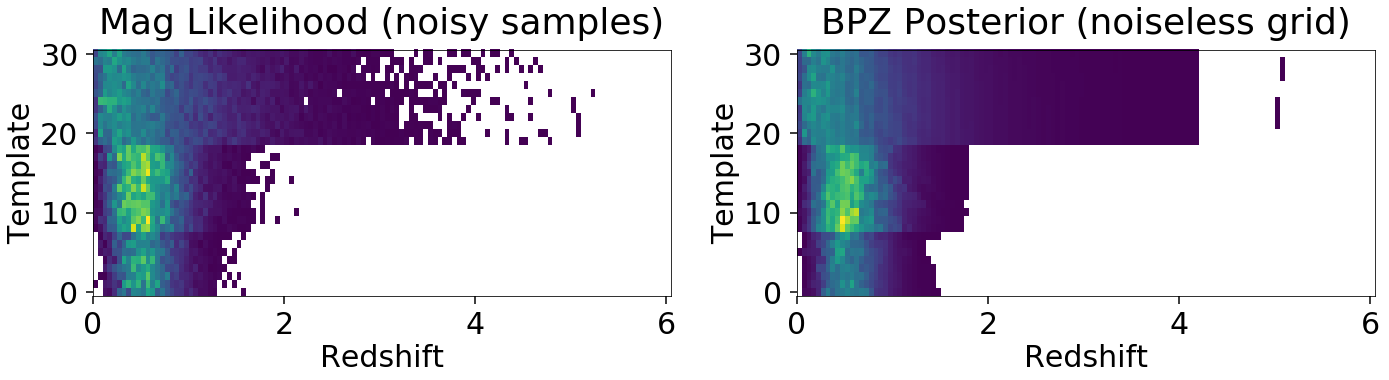

In [25]:
# plot redshift-template joint distribution
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plot_zt(redshifts[train_sel], templates[train_sel], 
        np.log(pstack1 + 1e-300), thresh=1e-2)
plt.title('Mag Likelihood (noisy samples)', y=1.04)
plt.subplot(1,2,2)
plot_zt(mredshifts, mtemplates, np.log(pstack3 + 1e-300),
        thresh=1e-2)
plt.title('BPZ Posterior (noiseless grid)', y=1.04);

Note that while the posterior computed here represents the absolute best case scenario where we know the underlying prior *exactly*, this is never true in practice. The expected performance for our BPZ-based posterior is therefore somewhere between the gray and blue distributions shown above. 

By contrast, our noisy, flux-based likelihoods only depend on our training data providing some form of access to the prior, irrespective of its underlying functional form. While here we've assumed it provides *direct* access, we will later relax this assumption using the Bayesian hierarchical model outlined in Part 2.

# Comparison 2: Mag (samples) vs Color (samples)

Just for completeness, we also show the difference between computing our results using magnitudes (as above) vs color (with and without accounting for observational errors).

In [26]:
pstack4, pstack5 = np.zeros(Ntrain), np.zeros(Ntrain)

for i in range(Ntest):
    if i%500 == 0: 
        sys.stderr.write(str(i)+' ')
    ll, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                      phot_train, err_train, mask_train,
                                      ignore_model_err=True, free_scale=True)
    ll2, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                       phot_train, err_train, mask_train,
                                       ignore_model_err=False, free_scale=True)
    
    pstack4 += np.exp(ll - logsumexp(ll))
    pstack5 += np.exp(ll2 - logsumexp(ll2))

0 500 1000 1500 2000 2500 3000 3500 4000 4500 

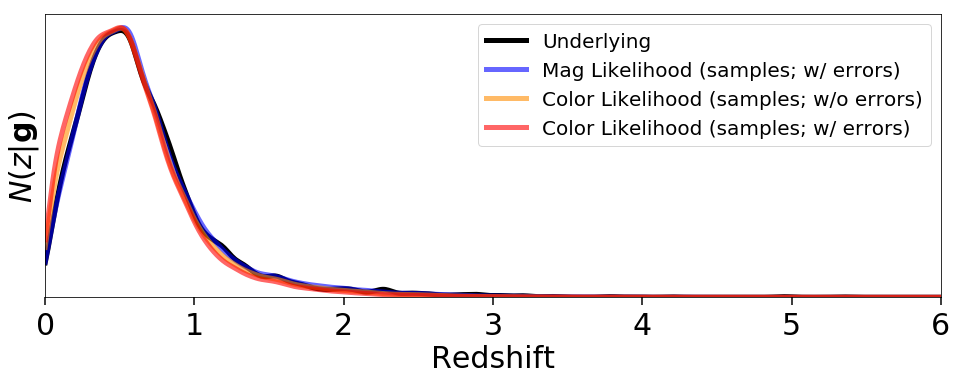

In [27]:
# color samples (ignoring noise)
zpdf4 = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[train_sel],
                                    y_std=np.ones_like(train_sel) * rsmooth, 
                                    y_wt=pstack4)

# color samples (including noise)
zpdf5 = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[train_sel],
                                    y_std=np.ones_like(train_sel) * rsmooth, 
                                    y_wt=pstack5)

# plotting
plt.figure(figsize=(14, 6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, zpdf1, lw=5, color='blue', alpha=0.6,
         label='Mag Likelihood (samples; w/ errors)')
plt.plot(rdict.grid, zpdf4, lw=5, color='darkorange', alpha=0.6,
         label='Color Likelihood (samples; w/o errors)')
plt.plot(rdict.grid, zpdf5, lw=5, color='red', alpha=0.6,
         label='Color Likelihood (samples; w/ errors)')
plt.xlim([0., 6.])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

Even among only a small number of objects, the difference between these two distributions is clear: **our color-based likelihoods are biased towards lower redshifts**. 

We can get a clearer picture as to why this is the case by looking at the joint template-redshift distribution.

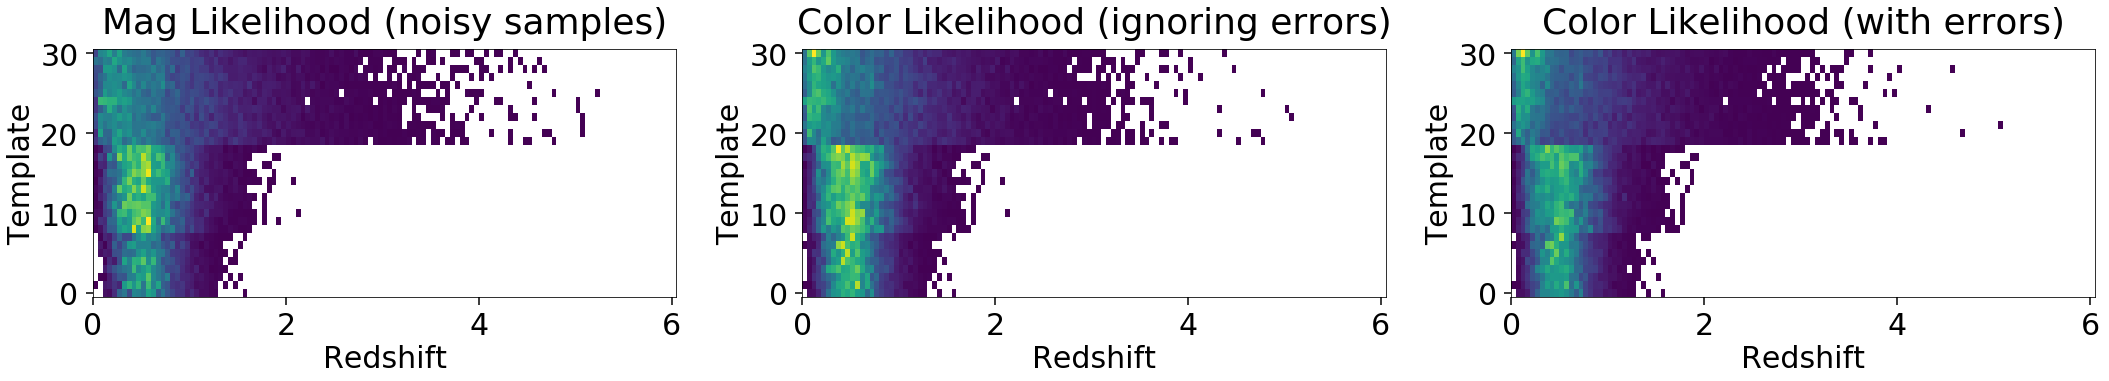

In [28]:
# plot redshift-template joint distribution
plt.figure(figsize=(30, 6))
plt.subplot(1,3,1)
plot_zt(redshifts[train_sel], templates[train_sel], 
        np.log(pstack1 + 1e-300), thresh=1e-2)
plt.title('Mag Likelihood (noisy samples)', y=1.04)
plt.subplot(1,3,2)
plot_zt(redshifts[train_sel], templates[train_sel], 
        np.log(pstack4 + 1e-300), thresh=1e-2)
plt.title('Color Likelihood (ignoring errors)', y=1.04)
plt.subplot(1,3,3)
plot_zt(redshifts[train_sel], templates[train_sel], 
        np.log(pstack5 + 1e-300), thresh=1e-2)
plt.title('Color Likelihood (with errors)', y=1.04);

We see the differences are due to us "double counting" our prior: since our samples are drawn from the prior, the magnitude contains information. Using colors (with or without errors) treats all similar objects the same, which gives more weight to redshifts where more objects are present (i.e. lower redshifts). This ends up giving more weight to an (on average) lower-redshift population of galaxies, distorting our population redshift estimate. **Note that this effect would almost certainly be exarcerbated in practice due to selection effects that bias our training samples to brighter galaxies.**

# Comparison 3: Brute-Force vs Sparse

We've now demonstrated that:
1. The original BPZ posterior is an unbiased probe of the underlying distribution (as expected).
2. Our magnitude-based likelihoods computed over unbiased training data provides is also an unbiased (but noisier) probe of the underlying distribution (as expected).

We now turn to the computational challenge of exploiting this training data. In particular, taking a brute-force approach (as we did above) is prohibitively slow. It also penalizes you harshly for expanding your training sample, which seems counter-productive.

To solve this issue (somewhat foreshadowed in our KDE discussion above), we turn to "machine learning". Specifically, we want to use machine learning to give us a **sparse approximation of the true likelihood distribution using a small but unbiased set of neighbors**. In other words, we want to select a small subset of objects ($N_{\mathrm{neighbor}} \ll N_{\mathrm{train}}$) and use the likelihoods evaluated over only those objects as an approximation of the overall likelihood.

## Sidenote: Nearest Neighbors and FRANKEN-Z

We use **k-d trees** to find neighbors in $\mathcal{O}(\log N)$ time (although this does strongly depend on dimensionality), which is a much softer penalty than the $\mathcal{O}(N)$ scaling imposed by brute-force approaches. Using an ensemble of k-d trees trained/queried with Monte Carlo realizations of the input fluxes, we can subsequently guarantee (in the limit of many objects and/or draws) an unbiased selection of (unique) neighbors gathered from across the ensemble that properly takes into account measurement errors within both datasets.

In [29]:
# initialize kNNMC instance
knn = frankenz.nn.kNNMC()
idxs, Nidxs = knn.query(phot_train, err_train, phot_test, err_test)

Progress: 25/25          
Progress: 5000/5000               

We can now generate a new set of "sparse" predictions using these set of neighbors.

In [30]:
# stack predictions
pstack_fz = np.zeros(Ntrain)
for i, (idx, Nidx) in enumerate(zip(idxs, Nidxs)):
    if i%500 == 0: 
        sys.stderr.write(str(i)+' ')
    j = idx[:Nidx]
    ll, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                      phot_train[j], err_train[j], mask_train[j])
    
    pstack_fz[j] += np.exp(ll - logsumexp(ll))

0 500 1000 1500 2000 2500 3000 3500 4000 4500 

Now let's turn these predictions into the population estimates we were previously using.

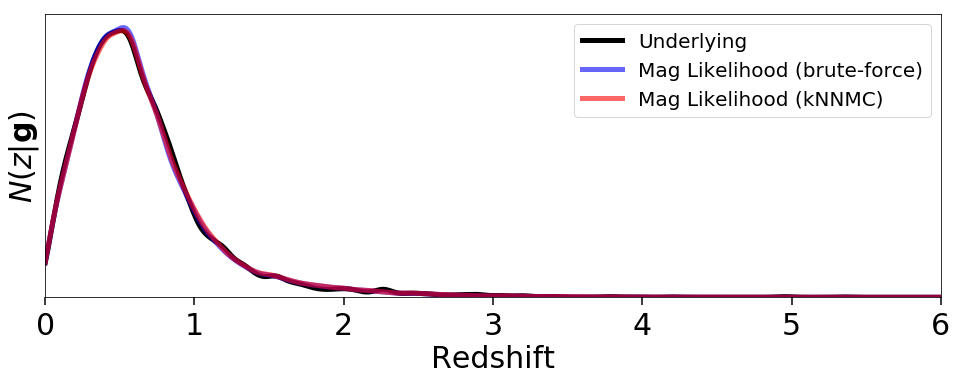

In [31]:
# sparse magnitude samples
zpdf_fz = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[train_sel],
                                      y_std=np.ones_like(train_sel) * rsmooth, 
                                      y_wt=pstack_fz)

# plotting
plt.figure(figsize=(14, 6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, zpdf1, lw=5, color='blue', alpha=0.6,
         label='Mag Likelihood (brute-force)')
plt.plot(rdict.grid, zpdf_fz, lw=5, color='red', alpha=0.6,
         label='Mag Likelihood (kNNMC)')
plt.xlim([0., 6.])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

These distributions are nearly identical, illustrating that our sparse, nearest-neighbor approximation works well.

# Comparison 4: Dependence on Neighbors and Sample Size

Due to the way we utilize training data (treating all objects as discrete comparisons rather than as samples from a continuous distribution), our comparisons using training data will be subject to some amount of Poisson (i.e. shot) noise based on our overall sample size and our effective number of neighbors. We want to quantify this below.

## Neighbor-dependence

Here we keep the overall number of objects in our training sample fixed, but vary the number of trees used in our approximation. Since each tree probes a separate Monte Carlo realization of our observables, this probes both the scope of our search as well as our ability to incorporate measurement errors.

In [32]:
# change trees
ntrees = [1, 2, 5, 10, 15, 20, 25]

# re-run analysis varying Ntrees
zpdfs = []
for n in ntrees:
    sys.stdout.write(str(n)+': \n')

    # compute predictions
    knn = frankenz.nn.kNNMC(M=n)
    idxs, Nidxs = knn.query(phot_train, err_train, phot_test, err_test)

    pstack = np.zeros(Ntrain)
    for i, (idx, Nidx) in enumerate(zip(idxs, Nidxs)):
        j = idx[:Nidx]
        ll, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                          phot_train[j], err_train[j], mask_train[j])

        pstack[j] += np.exp(ll - logsumexp(ll))

    # computing redshift distribution (sparse)
    zpdfs.append(frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[train_sel],
                                             y_std=np.ones_like(train_sel) * rsmooth, 
                                             y_wt=pstack))

1: 


Progress: 1/1          
Progress: 5000/5000               

2: 


Progress: 2/2          
Progress: 5000/5000               

5: 


Progress: 5/5          
Progress: 5000/5000               

10: 


Progress: 10/10          
Progress: 5000/5000               

15: 


Progress: 15/15          
Progress: 5000/5000               

20: 


Progress: 20/20          
Progress: 5000/5000               

25: 


Progress: 25/25          
Progress: 5000/5000               

/home/joshspeagle/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


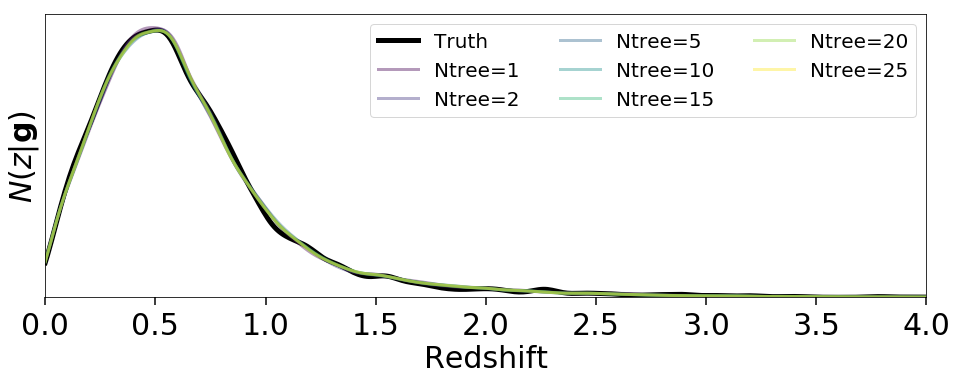

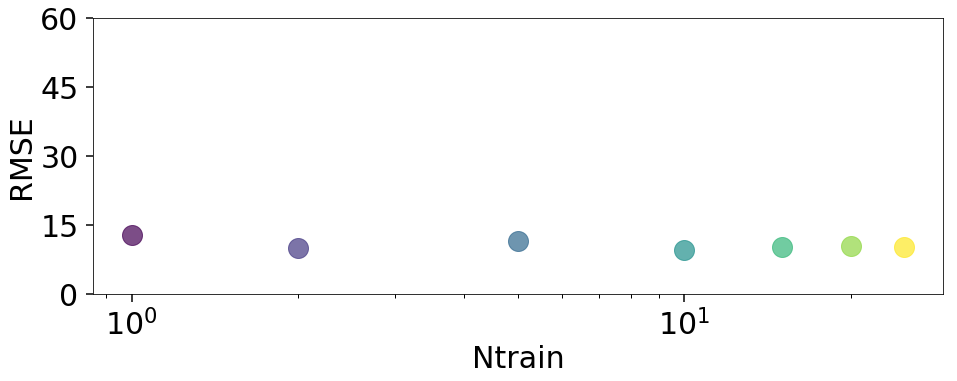

In [34]:
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(ntrees)))

# plotting
plt.figure(figsize=(14,6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black', label='Truth')
for i in range(len(zpdfs)):
    plt.plot(rdict.grid, zpdfs[i], lw=3, color=colors[i], alpha=0.4, 
             label='Ntree={0}'.format(ntrees[i]))
plt.xlim([0, 4])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20, ncol=3)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

# plotting MSE
plt.figure(figsize=(14,6))
for i in xrange(len(zpdfs)):
    plt.semilogx(ntrees[i], sum((zpdfs[i] - zpdf0)**2)**0.5, 
                 'o', markersize=20, color=colors[i], alpha=0.7)
plt.xlabel('Ntrain')
plt.ylabel('RMSE')
plt.yticks(np.arange(0, 60+1e-5, 15))
plt.tight_layout()

In the limit where we have plenty of training data (i.e. good coverage), our population results appear relatively robust to the number of trees (and hence neighbors) when aggregated across our ensemble. Put another way, the variance in our estimates is essentially negligible. **Note, however, that this ignores the impact of additional trees on predictions for individual objects, where it's obvious including more neighbors will improve the corresponding PDFs.**

## Sample-dependence

Now we fix the number of trees to 10 and vary our original sample size.

In [35]:
knn = frankenz.nn.kNNMC(M=10)

# downsample
downsample = [100, 50, 25, 10, 5, 2, 1]

# re-run analysis varying Ntrees
zpdfs2 = []
for d in downsample:
    sys.stdout.write(str(d)+': \n')

    # compute predictions
    ptemp, etemp, mtemp = phot_train[::d], err_train[::d], mask_train[::d]
    idxs, Nidxs = knn.query(ptemp, etemp, phot_test, err_test)

    pstack = np.zeros(Ntrain)
    for i, (idx, Nidx) in enumerate(zip(idxs, Nidxs)):
        j = idx[:Nidx]
        ll, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                          ptemp[j], etemp[j], mtemp[j])

        pstack[j] += np.exp(ll - logsumexp(ll))

    # computing redshift distribution (sparse)
    zpdfs2.append(frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[train_sel],
                                              y_std=np.ones_like(train_sel) * rsmooth, 
                                              y_wt=pstack))

100: 


Progress: 10/10          
Progress: 5000/5000               

50: 


Progress: 10/10          
Progress: 5000/5000               

25: 


Progress: 10/10          
Progress: 5000/5000               

10: 


Progress: 10/10          
Progress: 5000/5000               

5: 


Progress: 10/10          
Progress: 5000/5000               

2: 


Progress: 10/10          
Progress: 5000/5000               

1: 


Progress: 10/10          
Progress: 5000/5000               

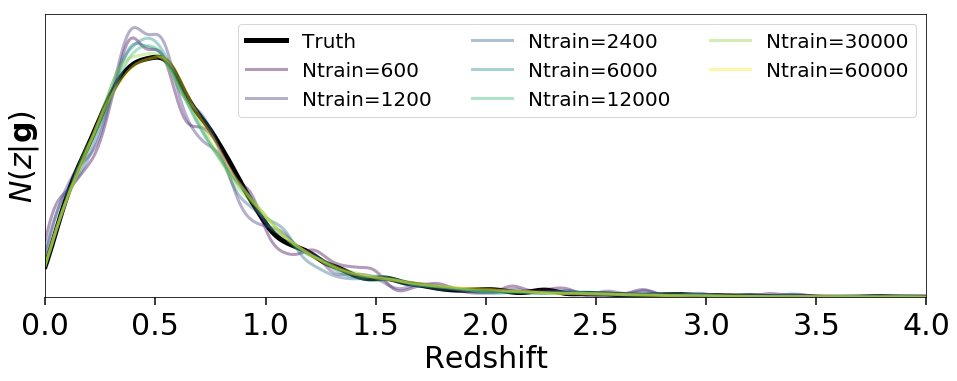

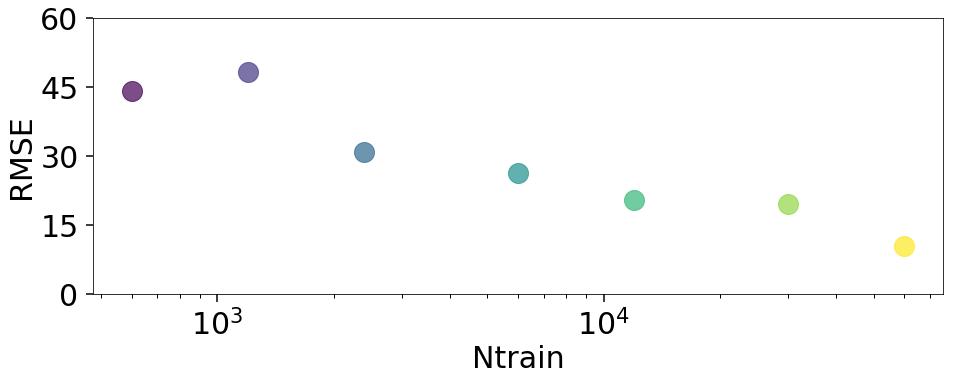

In [36]:
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(downsample)))

# plotting
plt.figure(figsize=(14,6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black', label='Truth')
for i in range(len(zpdfs2)):
    plt.plot(rdict.grid, zpdfs2[i], lw=3, color=colors[i], alpha=0.4, 
             label='Ntrain={0}'.format(int(Ntrain/downsample[i])))
plt.xlim([0, 4])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20, ncol=3)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

# plotting MSE
plt.figure(figsize=(14,6))
for i in xrange(len(zpdfs2)):
    plt.semilogx(int(Ntrain/downsample[i]), sum((zpdfs2[i] - zpdf0)**2)**0.5, 
                 'o', markersize=20, color=colors[i], alpha=0.7)
plt.xlabel('Ntrain')
plt.ylabel('RMSE')
plt.yticks(np.arange(0, 60+1e-5, 15))
plt.tight_layout()

We see that for our mock SDSS data, our gains appear to top out around 20-50k objects. We also note that the improvement here is pretty significant compared with the number of trees we utilize to compute our estimates. In other words, for most applications, getting more training objects (especially in regimes with poor sampling) will likely bring about significantly greater gains than improving the number of neighbors used in our fits (at least when it comes to our population estimates).

# Individual PDF Accuracy

In addition to be good in aggregate, we can also test how well we can predict the redshifts of individual objects.

In [37]:
# stack predictions
zpdfs_fz = np.zeros((Ntest, rdict.Ngrid))
ztrain = redshifts[train_sel]
for i, (idx, Nidx) in enumerate(zip(idxs, Nidxs)):
    if i%500 == 0: 
        sys.stderr.write(str(i)+' ')
    j = idx[:Nidx]
    ll, nbands = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                      phot_train[j], err_train[j], mask_train[j])
    
    wt = np.exp(ll - logsumexp(ll))
    zpdfs_fz[i] = frankenz.pdf.gauss_kde_dict(rdict, y=ztrain[j], 
                                              y_std=np.zeros_like(j), 
                                              y_wt=wt)

0 500 1000 1500 2000 2500 3000 3500 4000 4500 

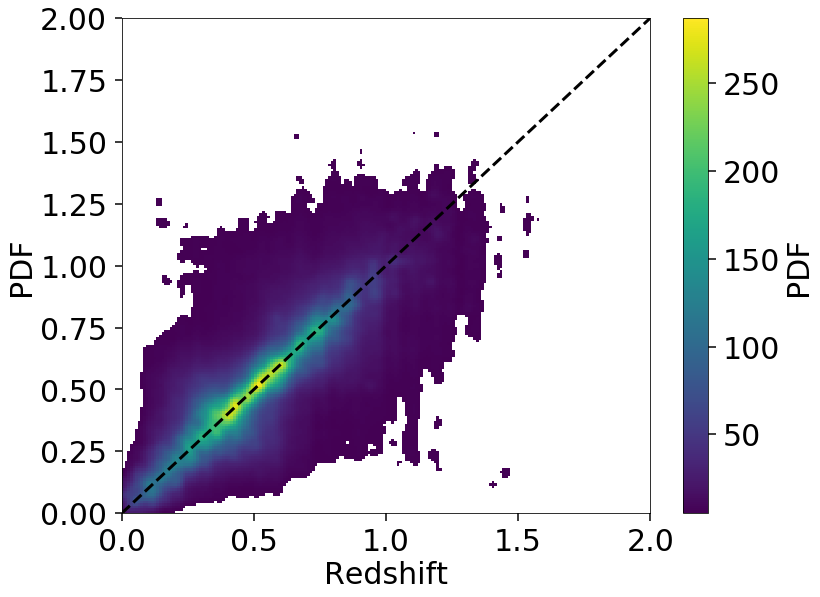

In [41]:
plt.figure(figsize=(12,9))
hh = frankenz.plotting.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                                    zpdfs_fz, rdict, plot_thresh=5, smooth=1.5)
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.xlim([0., 2.])
plt.ylim([0., 2.])
plt.tight_layout()

Our individual PDFs look excellent: the distributions are almost exactly symmetric! Overall, our results are quite robust: using the approximations in FRANKEN-Z, we are able to generate accurate PDFs at an individual and ensemble level in line with what we expect given our numerical approximations.